# Example of ISP Pipeline

In [1]:
import shutil
from pathlib import Path

import numpy as np
import rawpy
from PIL import Image

from configs.config_loader import config
from datasets.hdrplus_downloader import HDRPlusDatasetDownloader
from pipeline import ISPPipeline
from utils import get_exif_metadata, get_git_root, plot_images

%matplotlib inline
# Set the default figure format for inline matplotlib plots to JPEG for smaller file sizes and faster rendering
%config InlineBackend.figure_format = 'jpeg'
# Configure matplotlib to save figures with tight bounding boxes (removes extra whitespace)
%config InlineBackend.rc = {'savefig.bbox': 'tight'}

## Step 1. Download burst of raw files

In [2]:
downloader = HDRPlusDatasetDownloader()
source_path = Path(config.links.tree_example_path)
folder_path = downloader.download(source_path)

2026-02-28 19:16:47.472 | INFO     | datasets.hdrplus_downloader:download:56 - Destination path wasn't explicitly set. Downloading into `/Users/andreiaksionau/Developer/Computational_Photography/ISPFoundry/data/raw/hdrplus_dataset/0006_20160722_115157_431`
2026-02-28 19:16:47.473 | INFO     | datasets.hdrplus_downloader:download:61 - Folder already exists. Force download was disabled.


## Step 2. Load raw images and extract metadata

In [3]:
dng_paths = [p for p in sorted(folder_path.iterdir()) if p.match("payload_*.dng")]
metadata = get_exif_metadata(dng_paths)

raw_images = []
for p in dng_paths:
    with rawpy.imread(str(p)) as raw_obj:
        raw_image = raw_obj.raw_image.astype(np.float32)
        raw_images.append(raw_image)

# Defining the folder to which images after all ISP steps will be saved
save_to_folder = Path(get_git_root(), config.data.interim, folder_path.stem)
if save_to_folder.exists():
    shutil.rmtree(save_to_folder)

## Step 3. Execute ISP Pipeline

Running ISP Pipeline without providing list of pipeline steps. 

By default all steps are executed. The list of default steps is defined in the configs/config.yaml

In [4]:
isp_pipeline = ISPPipeline()
print(f"ISP Pipeline steps are: {isp_pipeline.steps}")

2026-02-28 19:16:48.456 | INFO     | pipeline:_discover_steps:33 - --- Discovering Pipeline Step Implementations ----
2026-02-28 19:16:48.457 | INFO     | pipeline:_discover_steps:36 - Loaded: black_level_subtraction


ISP Pipeline steps are: ['black_level_subtraction']


2026-02-28 19:16:48.492 | DEBUG    | utils:save_ndarray_as_jpg:183 - The input image has to be normalized in range [0, 1], but got in range [61.0, 814.0]. Normalizing automatically ...
2026-02-28 19:16:48.528 | INFO     | pipeline:run:77 - Executing step 1/1 `black_level_subtraction` 
2026-02-28 19:16:48.689 | INFO     | pipeline:run:84 - Step 1/1 `black_level_subtraction` took 0:00:00.161272
2026-02-28 19:16:48.716 | INFO     | pipeline:run:97 - Full run took 0:00:00.188118


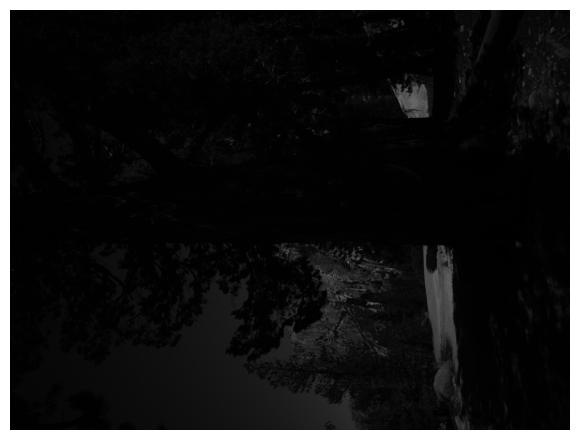

In [5]:
processed_imgs = isp_pipeline.run(raw_images, metadata, save_to_folder=save_to_folder)

# For now, since merging is not yet implemented, the output has the same number of images
# as the raw input.
# TODO (andrei aksionau): After merging is implemented there won't be need to do the indexing
plot_images(processed_imgs[0])

## Step 4. Display images after each step 

Since `save_to_folder` was provided into `run` method, images after each step were saved.

Now we can load them and display.

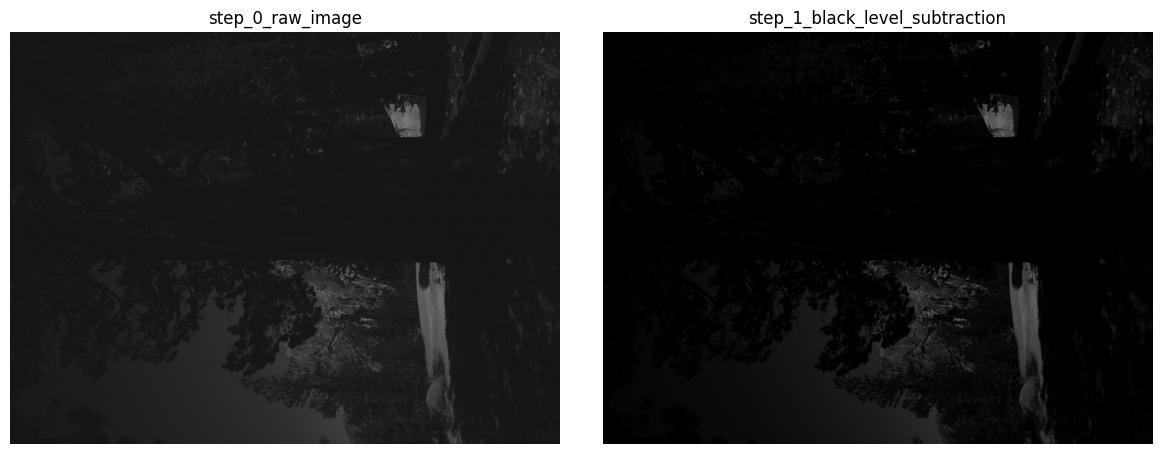

In [6]:
titles = []
images = []

for p in sorted(p for p in save_to_folder.iterdir() if p.match("*.jpg")):
    titles.append(p.stem)
    images.append(np.array(Image.open(p)))

plot_images(images, titles)